In [30]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import numpy as np
import matplotlib.pyplot as plt

In [31]:
DATA_DIR = "Dataset"                 
IMG_SIZE = (180, 180)
BATCH_SIZE = 32
SEED = 42
VAL_SPLIT = 0.15
TEST_SPLIT = 0.10                    
EPOCHS = 30

In [32]:
train_val_ds_raw = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb'
)
val_ds_raw = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb'
)

class_names = train_val_ds_raw.class_names
print("Classes:", class_names)

train_val_ds = train_val_ds_raw.apply(tf.data.experimental.ignore_errors())
val_ds = val_ds_raw.apply(tf.data.experimental.ignore_errors())

Found 24998 files belonging to 2 classes.
Using 21249 files for training.
Found 24998 files belonging to 2 classes.
Using 3749 files for validation.
Classes: ['Cat', 'Dog']


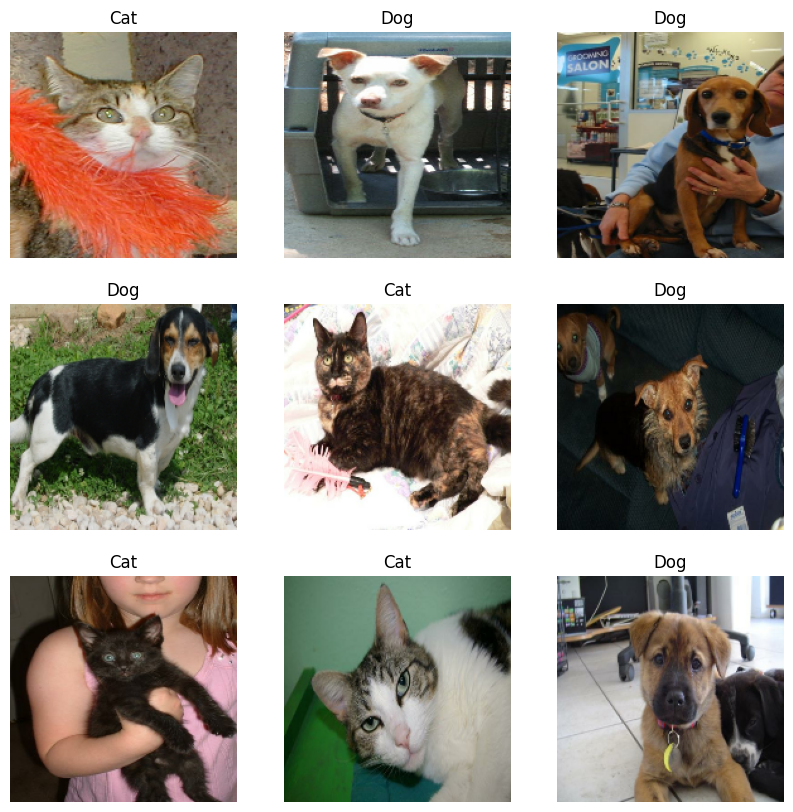

In [42]:
plt.figure(figsize=(10, 10))
for images, labels in train_val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [33]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")


In [34]:
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)   # Prevents overfitting


outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

In [35]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,              # stop if no improvement for 5 epochs
    restore_best_weights=True
)

history = model.fit(
    train_val_ds,       
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
    658/Unknown 276s 416ms/step - accuracy: 0.5645 - loss: 0.6824

C:\Users\dhruv\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


659/659 ━━━━━━━━━━━━━━━━━━━━ 292s 440ms/step - accuracy: 0.6104 - loss: 0.6532 - val_accuracy: 0.6998 - val_loss: 0.5876
Epoch 2/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 254s 385ms/step - accuracy: 0.7146 - loss: 0.5575 - val_accuracy: 0.7824 - val_loss: 0.4695
Epoch 3/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 286s 434ms/step - accuracy: 0.7636 - loss: 0.4958 - val_accuracy: 0.8006 - val_loss: 0.4392
Epoch 4/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 255s 388ms/step - accuracy: 0.8031 - loss: 0.4315 - val_accuracy: 0.8429 - val_loss: 0.3681
Epoch 5/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 259s 394ms/step - accuracy: 0.8278 - loss: 0.3813 - val_accuracy: 0.8432 - val_loss: 0.3594
Epoch 6/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 265s 402ms/step - accuracy: 0.8456 - loss: 0.3493 - val_accuracy: 0.8206 - val_loss: 0.3974
Epoch 7/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 268s 407ms/step - accuracy: 0.8688 - loss: 0.3073 - val_accuracy: 0.8805 - val_loss: 0.2960
Epoch 8/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 268s 407ms/step - accuracy: 0.8779 - loss: 0.29

In [38]:
val_loss, val_acc = model.evaluate(val_ds, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss    : {val_loss:.4f}")

117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.9233 - loss: 0.2030
Validation Accuracy: 0.9233
Validation Loss    : 0.2030


C:\Users\dhruv\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Text(0.5, 1.0, 'Loss')

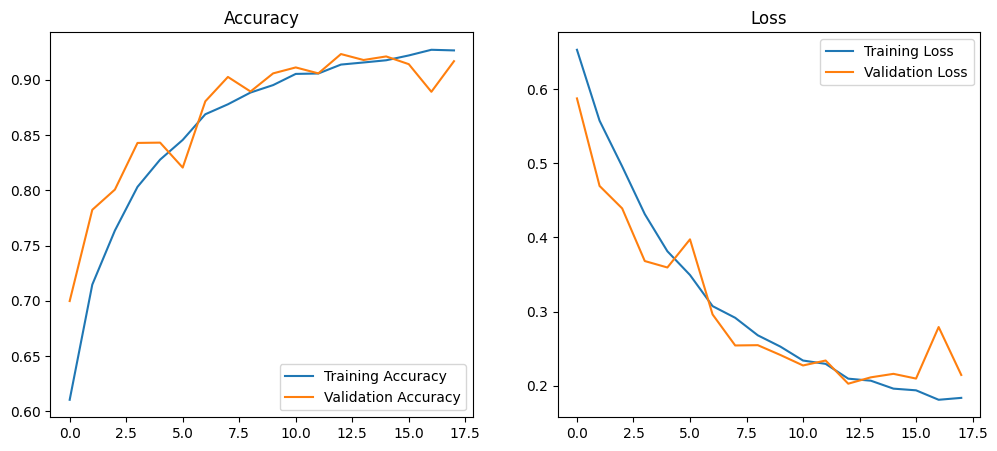

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')